In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
import tempfile
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import norm
import tqdm
import pickle
from itertools import combinations

from PIL import Image, ImageDraw
from multiprocessing import Pool, Manager
import copy
import uuid
from sklearn.preprocessing import StandardScaler
from aquabyte.optics import convert_to_world_point, depth_from_disp, pixel2world, euclidean_distance




In [2]:
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


sql_credentials = json.load(open(os.environ["SQL_CREDENTIALS"]))
sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                           sql_credentials["host"], sql_credentials["port"],
                           sql_credentials["database"]))

Session = sessionmaker(bind=sql_engine)
session = Session()

Base = automap_base()
Base.prepare(sql_engine, reflect=True)
Enclosure = Base.classes.enclosures
Calibration = Base.classes.calibrations
GtsfDataCollection = Base.classes.gtsf_data_collections
StereoFramePair = Base.classes.stereo_frame_pairs


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
model = pickle.load(open('../production_data_analysis/model.pkl', 'rb'))
blender = json.load(open('../production_data_analysis/volumes.json'))

In [4]:
def coord2biomass_linear(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - model['mean']) / model['std']
    X_transformed = np.dot(X_normalized, model['PCA_components'].T)
    prediction = np.dot(X_transformed, reg_coef) + reg_intercept
    return prediction


def coord2biomass_blender(world_keypoints, blender):
    """from coordinates to biomass"""

    # mapping helps for consistency with the kp order
    reverse_mapping = blender["reverse_mapping"]
    distances = np.array(blender["distances"])
    volumes = blender["volume"]
    regression_coeff = blender["coeff"]

    # calculate pairwise distances for production coord
    # the reverse mapping insure that we listing the kp
    # in the same order
    measurements = []
    number_of_parts = len(world_keypoints)
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    measurements = np.array(measurements)

    # absolute diff
    diff = np.nanmean(np.abs(distances - measurements), axis=1)
    closest = np.argmin(diff)
    prediction = volumes[closest]

    # here is some machine learning
    prediction = prediction*regression_coeff[0] + regression_coeff[1]
    return prediction

In [6]:
sfps_all = session.query(StereoFramePair).all()
df = pd.DataFrame()


session.rollback()
for idx, row in enumerate(sfps_all):
    if idx % 10 == 0:
        print(idx)
        
    # get fish_id and ground truth metadata
    if row.gtsf_fish_identifier == '190321010002':
        continue
    
    ground_truth_metadata = json.loads(row.ground_truth_metadata)
    if ground_truth_metadata['data'].get('species') != 'salmon':
        continue
        
    world_keypoint_coordinates = json.loads(row.world_keypoint_coordinates)
    biomass_linear = coord2biomass_linear(world_keypoint_coordinates, model)
    biomass_blender = coord2biomass_blender(world_keypoint_coordinates, blender)
    row = {
        'biomass_linear': biomass_linear,
        'biomass_blender': biomass_blender,
        'biomass_ground_truth': ground_truth_metadata['data']['weight'],
        'gtsf_fish_identifier': row.gtsf_fish_identifier
    }
    
    df = df.append(row, ignore_index=True)
    


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660


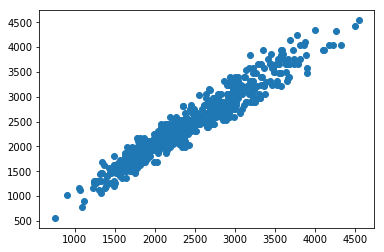

In [8]:
plt.scatter(df.biomass_ground_truth, df.biomass_blender)
plt.show()

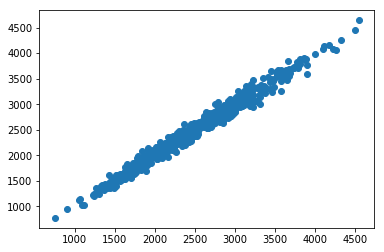

In [9]:
plt.scatter(df.biomass_ground_truth, df.biomass_linear)
plt.show()

In [10]:
np.corrcoef(df.biomass_blender, df.biomass_linear)

array([[1.        , 0.97514923],
       [0.97514923, 1.        ]])